In [71]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import datetime
import glob as glob
import datetime
import scipy
import sys
import os
import geopandas as gp
# import seaborn as sns
%matplotlib inline

## Rainfall dataset

We use the rainfall dataset produced by Levy et al. (2017):  

Levy, M. C. (2017). Curated rain and flow data for the Brazilian rainforest-savanna transition zone, HydroShare, http://www.hydroshare.org/resource/e82e66572b444fc5b6bf16f88f911f77

The data is interpolated using each day's active rain gauge data. Interpolations were done on a 0.25° resolution grid; the IDW parameter was set to 2 (default). The maximum interpolation distance (radius) was 1000m. The dataset was then sampled at all 5000 datapoints in `./data/sesync2018_points.geojson`, which were randomly generated (avoiding 'artificial surfaces' using GlobCover 2009, a global land cover map available in Google Earth Engine) within the Amazon and Cerrado biomes (note: some points were discarded because the rainfall dataset does not entirely cover the extent of the Amazon and Cerrado biomes). 

In [72]:
df = pd.read_csv('./data/sesync2018_points_rainIdw.csv', parse_dates=True, index_col=0)

In [3]:
# with a dataframe of daily rainfall totals for each site, 
# the mean wet season onset/end using the anomalous accumulation method from Liebmann et al. (2007)
# inputs: 
#     df: monthly time series dataframe of rainfall for all sites
#     wystartmonth: month of the start of the water year. Defaults to August. 
# outputs:
#     A dataframe, with index = point id's, a column for mean wet season onset day of the water year
#     and a column for mean wet season end day of the water year (all relative to wystartmonth)

def get_onset_dowy(df, wystartmonth=8):
    years = list(set(df.index.year))
    years.sort()
    site_daily_means = df.mean(axis=0)
    wet_onset = []
    wet_end = []
    for year in years: 
        start_date = str(year) + '-' + str(wystartmonth) + '-01'
        end_date = str(year+1) + '-' + str(wystartmonth)
        index=set(pd.date_range(start_date, end_date)[:-1]).intersection(set(df.index))
        dfyear = df.loc[index].sort_index()
        if len(dfyear)<365: 
            continue
        dowy = range(len(dfyear))
        dfyear.index = dowy
        aa = np.cumsum(dfyear - site_daily_means)
        wet_onset.append(aa.loc[0:150].idxmin())
        wet_end.append(aa.loc[150:365].idxmax())
    wet_onset = pd.concat(wet_onset, axis=1).T.mean()
    wet_end = pd.concat(wet_end, axis=1).T.mean()
    wet_onset_end = pd.concat([wet_onset, wet_end], axis=1)
    wet_onset_end.columns = ['wet_onset', 'wet_end']
    return wet_onset_end

# with a dataframe of daily rainfall totals for each site, and pre/post periods,
# get the mean wet season onset/end using the anomalous accumulation method from Liebmann et al. (2007)
# inputs: 
#     df: monthly time series dataframe of rainfall for all sites
#     pre: 2-tuple of start/stop years for the pre-treatment period
#     post: 2-tuple of start/stop years for the post-treatment period
#     wystartmonth: month of the start of the water year. Defaults to August. 
# outputs:
#     A dataframe, with index = point id's, columns for mean wet season onset day of the water year (pre/post)
#     and columns for mean wet season end day of the water year pre/post (all relative to wystartmonth)

def get_onset_dowy_prePost(df, pre, post, wystartmonth=8):
    dfpre = df.loc[pre[0]:pre[1]]
    dfpost = df.loc[post[0]:post[1]]
    ppre = get_onset_dowy(dfpre, wystartmonth=8)
    ppost = get_onset_dowy(dfpost, wystartmonth=8)
    ppre_post = ppre.join(ppost, lsuffix='_pre', rsuffix='_post')
    return ppre_post

In [4]:
pre = ('1980', '1990')
post = ('2000', '2010')
ppre_post = get_onset_dowy_prePost(df, pre, post, wystartmonth=8)
print(ppre_post.head())

   wet_onset_pre  wet_end_pre  wet_onset_post  wet_end_post
1           94.1        254.9            84.3         239.8
2           87.4        268.8            74.8         269.2
4           83.8        264.2            94.1         263.0
6          138.2        280.8           134.2         283.5
7           80.9        265.6            90.3         254.9


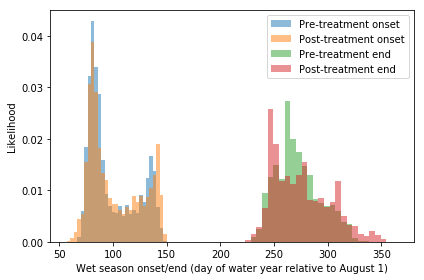

In [5]:
plt.figure()
bins = np.linspace(np.min([ppre_post.wet_onset_pre.min(), ppre_post.wet_onset_post.min()]), 150, 30)
plt.hist(ppre_post.wet_onset_pre,bins, alpha=0.5, label='Pre-treatment onset', normed=1)
plt.hist(ppre_post.wet_onset_post,bins, alpha=0.5, label='Post-treatment onset', normed=1)

bins = np.linspace(np.min([ppre_post.wet_end_pre.min(), ppre_post.wet_end_post.min()]), 365, 30)
plt.hist(ppre_post.wet_end_pre,bins, alpha=0.5, label='Pre-treatment end', normed=1)
plt.hist(ppre_post.wet_end_post,bins, alpha=0.5, label='Post-treatment end', normed=1)
plt.legend(loc='upper right')
plt.xlabel('Wet season onset/end (day of water year relative to August 1)')
plt.ylabel('Likelihood')
plt.tight_layout()

## Is there a significant change in wet season duration owing to the treatment? 

We will use a fixed-effects model to see if there is a change in the wet season duration between (arbitrarily chosen) control and treatment groups. This is a simple test that implicitly accounts for entity (site) and time fixed-effects. The coefficient on the `treatmentstatus` variable (call it $\tau$) measures the differential effect of the treatment on the metric ($y$; in this case, the wet season duration): 

$\tau = (\overline{y}_{treated, post} − \overline{y}_{treated, pre}) − (\overline{y}_{control, post} − \overline{y}_{control, pre})$

Because the treatment and control groups here are chosen completely at random, we do not expect to see any differences between the groups. 

In [6]:
# TODO UPDATE THIS FOR DURATION

# test = pd.DataFrame.from_dict({0:Ss[0,:], 1:Ss[1,:]})
# test['treated'] = np.random.randint(0,2,len(test))
# test['id'] = df.columns
# tofit = test.melt(value_vars = [0, 1], id_vars = ['treated', 'id'])
# tofit['treatmentstatus'] = tofit.treated*tofit.variable
# tofit = tofit.set_index(['id', 'variable'])
# res = PanelOLS(tofit.value, tofit.treatmentstatus, entity_effects=True, time_effects=True).fit()
# print(res)

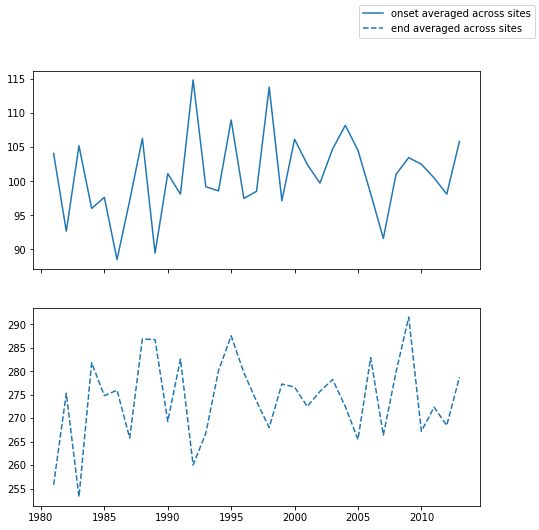

In [67]:
pts = gp.read_file('./data/sesync2018_points.geojson')
dfend = pd.read_csv('./data/wet_end_year_site.csv', index_col=0)
dfonset = pd.read_csv('./data/wet_onset_year_site.csv', index_col=0)

f, axs = plt.subplots(2, sharex=True, figsize=(8,8))
dfonset.mean(axis=1).plot(label='onset averaged across sites', ax=axs[0])
dfend.mean(axis=1).plot(label='end averaged across sites', ax=axs[1], ls='--')
f.legend()

Text(0.5,15,'lon')

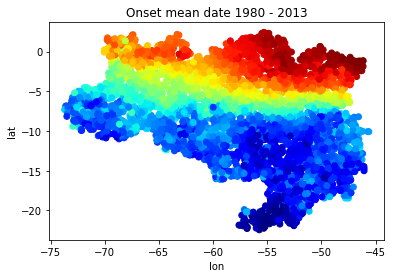

In [70]:


dfonsetmean = pd.DataFrame(np.transpose(np.vstack([dfonset.mean(axis=0).values, dfonset.mean(axis=0).index])), columns=['onset', 'id'])
pts = pts.merge(dfonsetmean, left_on='id', right_on='id')

f,ax = plt.subplots(1)
pts.plot('onset', ax=ax, cmap='jet')
ax.set_title('Onset mean date 1980 - 2013')
plt.ylabel('lat')
plt.xlabel('lon')

In [80]:
wystartmonth = 8
df = pd.read_csv('./data/rainfall_idw_500points.csv', parse_dates=True,index_col=0)
years = list(set(df.index.year))
years.sort()
site_daily_means = df.mean(axis=0)
wet_onset = []
wet_end = []
for year in years: 
    start_date = str(year) + '-' + str(wystartmonth) + '-01'
    end_date = str(year+1) + '-' + str(wystartmonth)
    index=set(pd.date_range(start_date, end_date)[:-1]).intersection(set(df.index))
    dfyear = df.loc[index].sort_index()
    if len(dfyear)<365: 
        continue
    dowy = range(len(dfyear))
    dfyear.index = dowy
    aa = np.cumsum(dfyear - site_daily_means)
    wet_onset.append(aa.loc[0:150].idxmin())
    wet_end.append(aa.loc[150:365].idxmax())
    dfyear = dfyear.T
    dfyear.to_csv('./data/' + 'rainfall_dowy_' + str(year+1) + '.csv')
